##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
#Here we are imoorting all the  necessary libraries

import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#this step helps us to open the csv file and focus on one particular column called LVMPD_States

orig_df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
#agian we are opening the book and working with 6 different columns and
#Also creating new cols Dayofweek and time and removing or dropping the reportedon col

df = pd.read_csv('/content/LVMPD-Stats.csv', parse_dates=['ReportedOn'],usecols = ['X', 'Y', 'ReportedOn',
                  'Area_Command','NIBRSOffenseCode', 'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
#Here we are basicallly doing data transforming and organising it done so that we can work with it.

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
#here we are trying to create like a subset to work with a managable data for our analysis

df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode','DayOfWeek', 'Time','VictimCount']]

In [6]:
#Here we are trying to find the size of data: first value = to number of rows and second value = to num of cols
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [7]:
#Task1.1
print(df.head())

#Here we are trying to to print first 5 rowns using head function

#Meaning of the data in each column:
#X column = horizontal location or latitude.
#Y column = vertical location or longitude.
#Area_Command column = contains a code that specifies the police bureau or area
#NIBRSOffenseCode column = contains a code that classifies the type of crime
#DayOfWeek column = represents the day of the week when the first incident was reported
#Time = column represents the hour of the day
#VictimCount column = indicates the number of people involved


#Task1.2
#Here the input variabales are : X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time and output variable is VictimCount


#Task1.3
#for X and Y = latitude values to be in the range of -90 to 90 and longitude values to be in the range of -180 to 180 (degrees)
#for Area_Commanad = it doesn't have a numeric range
#for NIBRSOffenseCode = range of values depends on the specific codes
#for DayOfWeek and Time =  0 to 6 and 0 to 23
#normalize/scaling//shift depends on the algo we will use



            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Now lets convert our DataFrame - df to tensors for perforning operations on it
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)


# Lets define our batch size - determines how many data points are processed together in each iteration
batch_size = 64


#Task2.1
# Lets create a DataLoader for training and testing - helps us to handle large dataset easily
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))  # Let assume an 80-20 split for training and testing


train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
#Task2.2
#printing the shape of data and verifying it

for batch in train_loader:
    inputs, targets = batch
    print("Batch Input Shape:", inputs.shape)
    print("Batch Target Shape:", targets.shape)
    break

Batch Input Shape: torch.Size([64, 6])
Batch Target Shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [10]:
#Here I have used MSE as a loss function i.e Mean Squared Error
#As we are predicting a single real number, the size of output should be one.
#The model we have used is regression model for the feedforward neural network.
#The architecture that consists of an input layer, one or more hidden layers, and an output layer with a single neuron.
#Here we have used ReLU activation functions in hidden layers.
#we have also used Adam's Optimizer and a learning rate of 0.001
#after multiple runs I have finallised these parameters where in I found the model well trainied with least mse



import torch
import torch.nn as nn
import torch.optim as optim

# Define your neural network class
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = 6  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer (you can adjust this)
output_size = 1  # Single output for regression
model = RegressionModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Training loop
num_epochs = 100  # Adjust the number of training epochs
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate MSE on the test data
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {total_loss/len(train_loader):.4f}, Test MSE: {test_loss/len(test_loader):.4f}')

# The model is now trained


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [1/100] - Train Loss: 45.1689, Test MSE: 13.1997
Epoch [2/100] - Train Loss: 7.4725, Test MSE: 2.0361
Epoch [3/100] - Train Loss: 3.8047, Test MSE: 9.3609
Epoch [4/100] - Train Loss: 8.7290, Test MSE: 9.6348
Epoch [5/100] - Train Loss: 6.6877, Test MSE: 4.1318
Epoch [6/100] - Train Loss: 2.2170, Test MSE: 1.5583
Epoch [7/100] - Train Loss: 1.9142, Test MSE: 2.3361
Epoch [8/100] - Train Loss: 2.8556, Test MSE: 2.4800
Epoch [9/100] - Train Loss: 2.5285, Test MSE: 1.6206
Epoch [10/100] - Train Loss: 1.5071, Test MSE: 1.5555
Epoch [11/100] - Train Loss: 1.4054, Test MSE: 2.0283
Epoch [12/100] - Train Loss: 1.6028, Test MSE: 1.8876
Epoch [13/100] - Train Loss: 1.3827, Test MSE: 1.4785
Epoch [14/100] - Train Loss: 1.3030, Test MSE: 1.3313
Epoch [15/100] - Train Loss: 1.2570, Test MSE: 1.3126
Epoch [16/100] - Train Loss: 1.2762, Test MSE: 1.2882
Epoch [17/100] - Train Loss: 1.1618, Test MSE: 1.3038
Epoch [18/100] - Train Loss: 1.2313, Test MSE: 1.3366
Epoch [19/100] - Train Loss: 1.2667

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [11]:
#Here we are working with classification problem,
#To find the number of output : we will determine the range of possible values for the number of crime victims. Each unique value within this range represents a class
#As it is a classification problem, we generally use a softmax activation function in the output layer , where in the number of output neurons match with number of classes
#For classification problems; Cross-Entropy Loss  is genrally used as a loss function
#after trying various parameters, following is the code I finalized
#best acc for this model is 0.5500



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define your neural network class for classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = 6  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer (adjust as needed)
num_classes = 11  # Number of classes (adjust based on the range of crime victims)
model = ClassificationModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Training loop with accuracy calculation
num_epochs = 100  # Adjust the number of training epochs
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Convert the target tensor to Long data type
        targets = targets.long()

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}')

# The model is now trained


Epoch [1/100] - Train Loss: 8.2675, Accuracy: 0.0636
Epoch [2/100] - Train Loss: 2.6255, Accuracy: 0.4045
Epoch [3/100] - Train Loss: 2.0393, Accuracy: 0.5136
Epoch [4/100] - Train Loss: 2.2567, Accuracy: 0.4182
Epoch [5/100] - Train Loss: 2.2413, Accuracy: 0.5227
Epoch [6/100] - Train Loss: 2.0006, Accuracy: 0.5182
Epoch [7/100] - Train Loss: 2.0070, Accuracy: 0.4364
Epoch [8/100] - Train Loss: 1.8810, Accuracy: 0.4955
Epoch [9/100] - Train Loss: 1.8042, Accuracy: 0.5182
Epoch [10/100] - Train Loss: 1.6061, Accuracy: 0.4727
Epoch [11/100] - Train Loss: 1.4752, Accuracy: 0.4864
Epoch [12/100] - Train Loss: 1.4592, Accuracy: 0.4773
Epoch [13/100] - Train Loss: 1.2472, Accuracy: 0.4818
Epoch [14/100] - Train Loss: 1.1768, Accuracy: 0.4909
Epoch [15/100] - Train Loss: 1.2238, Accuracy: 0.4909
Epoch [16/100] - Train Loss: 1.2537, Accuracy: 0.4818
Epoch [17/100] - Train Loss: 1.1540, Accuracy: 0.4909
Epoch [18/100] - Train Loss: 1.1348, Accuracy: 0.5045
Epoch [19/100] - Train Loss: 1.1677, 

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Misclassified Example:
Predicted Class: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Correct Class: [1.0, 1.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 3.0, 3.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 3.0, 0.0, 0.0, 1.0, 1.0, 3.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0]
11


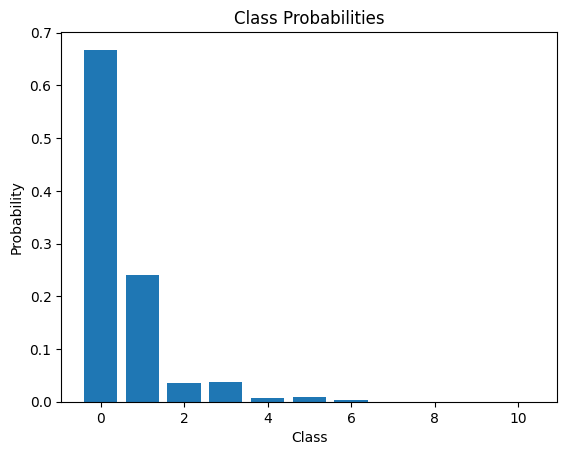

In [12]:
#In task 3, we performed regression to predict the exact number of crime victims, resulting in a Mean Squared Error (MSE) of 1.09. In task 4, classification was used to categorize the number of victims, achieving an accuracy of 0.55. The choice between regression and classification depends on specific requirements and data characteristics. While regression provides precise predictions, classification is better for categorizing data into predefined classes.


# Assuming 'test_loader' contains your test data
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted_class = torch.argmax(outputs, dim=1)
        correct_class = targets
        if not (predicted_class == correct_class).all():
            print(f'Misclassified Example:')
            print(f'Predicted Class: {predicted_class.tolist()}')
            print(f'Correct Class: {correct_class.tolist()}')

            # Calculate class probabilities
            class_probabilities = torch.softmax(outputs, dim=1)
            print(num_classes)

            # Plot the class probabilities
            classes = list(range(num_classes))  # Assuming 'num_classes' is defined
            probabilities = class_probabilities[0].tolist()
            plt.bar(classes, probabilities)
            plt.xlabel('Class')
            plt.ylabel('Probability')
            plt.title('Class Probabilities')
            plt.show()
            break  # Stop after the first misclassification for illustration


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


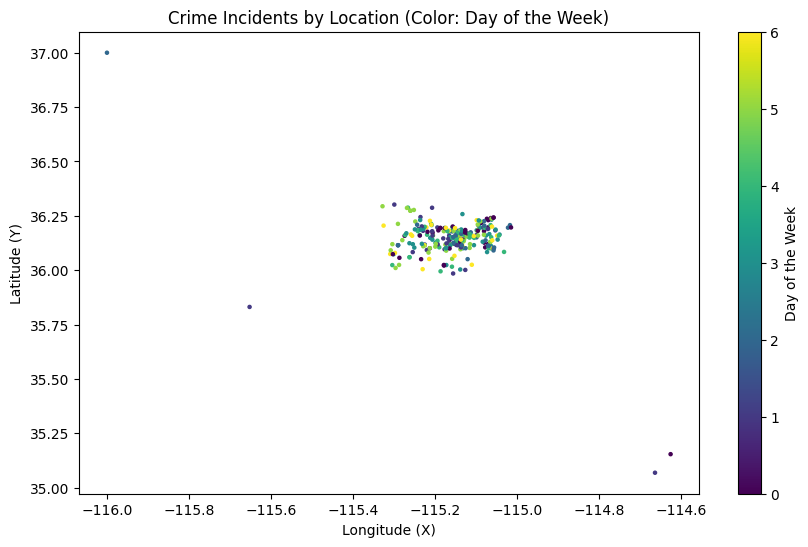

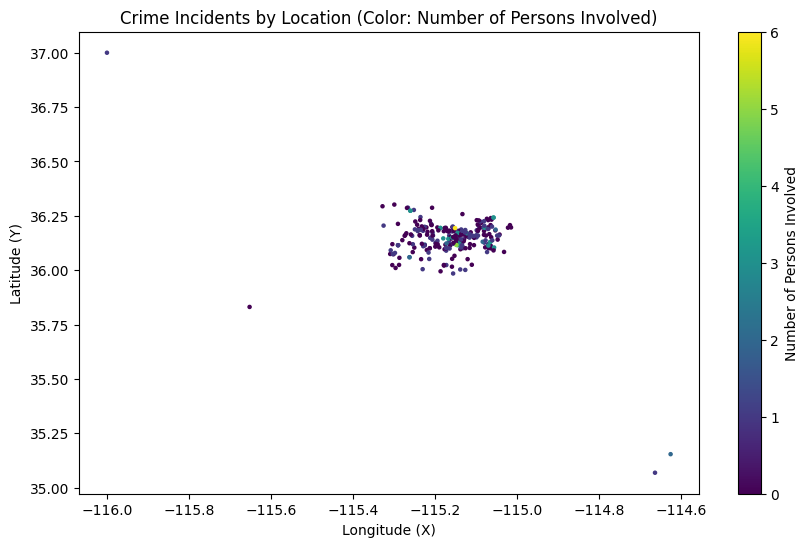

Number of Crimes by Day of the Week:
Monday: 40 crimes
Tuesday: 37 crimes
Wednesday: 32 crimes
Thursday: 44 crimes
Friday: 51 crimes
Saturday: 43 crimes
Sunday: 28 crimes
The most frequent day is: Friday


In [13]:
#the first scatter plot is represnting day of the week while second one is indicating number of persons involved
#more the cluster with similar datapoints shows that particular day and number of people involved in a particular region

import matplotlib.pyplot as plt
import numpy as np


# Create a scatter plot with colors indicating the day of the week
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', s=5)
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents by Location (Color: Day of the Week)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

# Create a scatter plot with colors indicating the number of persons involved
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=5)
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents by Location (Color: Number of Persons Involved)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

# Use numpy to sort the number of crimes reported by the day of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crime_counts_by_day = df['DayOfWeek'].value_counts().reindex(range(7), fill_value=0)
sorted_crime_counts = [crime_counts_by_day[day] for day in range(7)]
most_frequent_day = days_of_week[np.argmax(sorted_crime_counts)]

print(f"Number of Crimes by Day of the Week:")
for day, count in zip(days_of_week, sorted_crime_counts):
    print(f"{day}: {count} crimes")

print(f"The most frequent day is: {most_frequent_day}")
